In [1830]:
# TASK DEFINITIONS
tasks = {
    # Custom Actions
    "brush teeth": {
        "needs": {"toothpaste": 1},  # Requires 1 unit of water
        "depletes": {"toothpaste": 1},  # Depletes 1 unit of toothpaste
        "place": "bathroom",  # Needs to be in the bathroom
        "cost": 15,  # Cost of brushing teeth
    },
    "drink water": {
        "needs": {"water": 1},  # Requires 1 unit of water
        "depletes": {"water": 1},  # Depletes 1 unit of water
        "place": "kitchen",
        "cost": 5,
    },
    "clean dish": {
        "needs": {"soap": 1},  # Requires 1 unit of soap
        "depletes": {"soap": 1},  # Depletes 1 unit of soap
        "place": "kitchen",
        "cost": 12,
    },
    "make soup": {
        "needs": {"water": 1, "tomato": 1},  # Requires 1 unit of water
        "depletes": {"water": 1, "tomato": 1},  # Depletes 1 unit of water
        "place": "kitchen",
        "cost": 12,
    },
    # Buy actions with costs
    "buy water": {
        "needs": {},  # No specific resource needs
        "depletes": {},  # No resources are depleted
        "place": "store",
        "cost": 20,
    },
    "buy toothpaste": {
        "needs": {},  # No specific resource needs
        "depletes": {},  # No resources are depleted
        "place": "store",
        "cost": 10,
    },
    "buy soap": {
        "needs": {},
        "depletes": {},
        "place": "store",
        "cost": 3,
    },

    # Refill actions with costs
    "refill toothpaste": {
        "needs": {},  # No specific resource needs
        "depletes": {},  # No resources are depleted
        "place": "storage",
        "cost": 6,
    },
    "refill soap": {
        "needs": {},
        "depletes": {},  
        "place": "storage",
        "cost": 1,
    },

    # INTERFACE
    "go to": {
        "needs": {},  # No specific resource needs  
        "depletes": {},  # No resources are depleted
        "place": {},
        "cost": 5,
    },
    "check": {
        "needs": {},
        "depletes": {},
        "place": {},
        "cost": 3,
    },
    "check inventory": {
        "needs": {},
        "depletes": {}, 
        "place": {},
        "cost": 1,
    }
    
}
temp_tasks = tasks.copy()

In [1831]:
# STORAGES
main_stock = {}  # Main stock for refilling room-specific stocks
room_stocks = {}

In [1832]:
# CHECK LEVELS OF RESOURCE
def check_needs(task, stringify=False):
    task = task.lower()
    if stringify:
        string = [f"{value} {key}" for key, value in tasks.get(task, {}).get("needs", {}).items()]
        formatted_string = ", ".join(string)
        if formatted_string == "":
            formatted_string = "no resources."
        return formatted_string
    else:
        return tasks.get(task, {}).get("needs", {})

# Method to check what a task depletes
def check_depletes(task):
    return tasks.get(task, {}).get("depletes", {})

def check_place(task):
    return tasks.get(task, {}).get("place", "")

def check_main_stock(resource):
    return main_stock.get(resource, 0)

# Method to check stock in a specific room
def check_room_stock(room, resource):
    return room_stocks.get(room, {}).get(resource, 0)

In [1833]:
print(check_needs("Clean dish", stringify=True))

1 soap


In [1834]:
# INITIALIZE PLAYER AND GAME
player_location = "bedroom"  # Starting location
total_cost = 0  # Track total cost

In [1835]:
# Initialize main stock with resources
def init_main_stock(resources):
    global main_stock
    main_stock = resources.copy()

def init_room_stock(resources):
    global room_stocks
    room_stocks = resources.copy()

In [1836]:
# Method to refill resources in a room from the main stock
def refill_room(room, resource, X):
    global total_cost, main_stock, room_stocks
    if main_stock.get(resource, 0) >= X:
        room_stocks[room][resource] += X
        main_stock[resource] -= X
        print(f"Refilled {X} {resource}(s) in the {room}. Main stock left: {main_stock[resource]}.")
        return True
    else:
        print(f"Not enough {resource} in the storage to refill {room}. Needed: {X}, Available: {main_stock.get(resource, 0)}.")
        return False

# Method to buy resources from the store to replenish the main stock
def buy_resource(resource, X):
    global total_cost, room_stocks, main_stock
    if room_stocks["store"].get(resource, 0) >= X:
        room_stocks["store"][resource] -= X
        main_stock[resource] = main_stock.get(resource, 0) + X
        print(f"Bought {X} {resource}(s) from the store. ")
        return True
    else:
        print(f"Store doesn't have enough {resource}. Needed: {X}, Available: {room_stocks['store'].get(resource, 0)}.")
        return False

# Method to change location
def goto(place):
    global player_location, total_cost
    if player_location != place:
        player_location = place
        print(f"Moved to {place}.")
    else:
        print(f"Already at {place}.")
    
# Method to check current location
def where():
    return player_location

In [1837]:
def check_task_exist(task):
    amount = 0
    room = ''
    resource = 'NOT FOUND - the task existor checker'
    # go to storage
    if 'go to' in task:
         task = task.split()
         return True, ' '.join(task[:2]), 0, '', ' '.join(task[2:])
    
    # check inventory for water
    if 'check inventory' in task:
         # WARNING! check inventory does not return resource name
         return True, task.split()[0] + ' ' + task.split()[1], 0, '', ''
    
    # check kitchen for soap
    if 'check' in task:
         return True, task.split()[0], 0, '', ''
    
    # Buy 5 apple
    if 'buy' in task:
        task = task.split()
        amount = task[1]
        resource = ' '.join(task[2:])
        task.pop(1)
        task = ' '.join(task)

    # Refill kitchen with 6 water
    if 'refill' in task:
        words = task.split()
        index = words.index('with')
        amount = words[index+1]
        resource = ' '.join(words[index+2:])
        task = 'refill '
        for word in words:
            if word.isdigit():
                task += ' '.join(words[words.index(word)+1:])
                room = ' '.join(words[1:words.index(word)-1])
        
        
    if task not in tasks:
        print(f"Task '{task}' not recognized.")
        return False, task, amount, resource, room
    else:
        return True, task, amount, resource, room
    
print(check_task_exist("go to living room"))

['go', 'to', 'living', 'room']
(True, 'go to', 0, '', 'living room')


In [1838]:
def lowercase_list(input_list):
    return [item.lower() for item in input_list]

In [1839]:
def check_task_coverage(list1, list2):
    # Checks if the og list is a subset of the candidate list
    return set(list2).issubset(set(list1))

In [1840]:
# Function to execute tasks

def execute_tasks(task_list, needed_tasks):
    print("Now executing", task_list, "AGAINST", needed_tasks)

    def get_return_func(outcome):
        return outcome, accuracy, total_cost
    
    # Set up cost variables
    global total_cost
    total_cost = 0

    # Tracking accuracy
    completed_tasks = []
    accuracy = 0

    task_list = lowercase_list(task_list)
    needed_tasks = lowercase_list(needed_tasks)

    if not check_task_coverage(task_list, needed_tasks):
        print("given task list is not a subset of needed tasks")
    for task in task_list:
        task = task.lower()
        print("Now executing", task)
        quant = False
        # Check if task exists
        bool_key = check_task_exist(task) # (Task valid bool, viable task key, amount, resource, room)
        if not bool_key[0]:
            return get_return_func("Failure, the task does not exist in the task dictionary.")
        
        elif 'check inventory' in task:
            resource = task.split()[3]
            print(check_main_stock(resource))

        elif 'check' in task:
            room = task.split()[1]
            resource = task.split()[3]
            print(check_room_stock(room, resource))

        elif 'go to' in task or 'Go to' in task:
            place = bool_key[4]
            goto(place)
        else:
            place = check_place(bool_key[1])
        
            # Now process place conditioned tasks
            if where() != place:
                print(f'Must be at {place}. You are at {where()}.')
                return get_return_func("Failure" + f'Must be at {place}. You are at {where()}.')


            elif 'buy' in task:
                resource = bool_key[3]
                quantity = int(bool_key[2])
                buy_success = buy_resource(resource, quantity)
                if not buy_success:
                    return f"Failure, buying {resource} failed. Walmart doesnt have enough {resource}.", accuracy, total_cost
                quant = True

            elif 'refill' in task:
                room = bool_key[4]
                resource = bool_key[3]
                quantity = int(bool_key[2])
                refill_success = refill_room(room, resource, quantity)
                if not refill_success:
                    return f"Failure, refilling {resource} in {room} failed", accuracy, total_cost
                quant = True
            else:
                # Check if required resources are available in the current room
                needs = check_needs(task)
                for resource, amount in needs.items():
                    if check_room_stock(where(), resource) < amount:
                        print(f"Not enough {resource} in {where()} to complete {task}. Needed: {amount}, Available: {check_room_stock(where(), resource)}.")
                        return get_return_func("Failure, !needs_req" + f"Not enough {resource} in {where()} to complete {task}. Needed: {amount}, Available: {check_room_stock(where(), resource)}.")
                
                # Deplete resources from the room stock
                depletes = check_depletes(task)
                for resource, amount in depletes.items():
                    if check_room_stock(where(), resource) >= amount:
                        print(where(), resource, amount)
                        room_stocks[where()][resource] -= amount
                        print(f"Depleted {amount} {resource}(s) in {where()} for {task}. Remaining: {room_stocks[where()][resource]}")
                    else:
                        print(f"Not enough {resource} in {where()} to complete {task}. Needed: {amount}, Available: {check_room_stock(where(), resource)}.")
                        return get_return_func("Failure" + f"Not enough {resource} in {where()} to complete {task}. Needed: {amount}, Available: {check_room_stock(where(), resource)}.")

        # Add task cost to total cost
        task_cost = tasks[bool_key[1]]["cost"]
        if quant == True:
            task_cost = quantity * task_cost
        total_cost += task_cost

        if task in needed_tasks:
            completed_tasks.append(task)
        accuracy = len(completed_tasks) / len(needed_tasks)
        print(f"Executed {task} for cost {task_cost}. New total cost: {total_cost}")
    
    print(f"All tasks executed successfully. Total cost: {total_cost}")
    return get_return_func("Success")

In [1875]:
def prompt_maker(task_list, CoT = False):
    print("WELCOME TO THE GAME")
    initial_prompt = f"Hello! You are a butler in a home that has many rooms and a storage that acts as a pantry. You goal is to finish the tasks I will give you. Beware! These tasks require resources and may even deplete resources. You can use the storage to refill them! If even the storage doesn't have enough resources, you can buy from the store! \n"
    initial_prompt += f"You are standing in the {where()}. The home has: \n"
    # TODO: specify amount needed for each task
    
    # Give the agent rooms and their stock counts.
    room_str = ''
    for key, sub_dict in room_stocks.items():
        # Create a list of "value subkey" pairs
        sub_items = [f"{value} {sub_key}" for sub_key, value in sub_dict.items()]
        if sub_items == []:
            continue
        
        # Join the items with commas and "and" for the last item
        sub_items_joined = ", ".join(sub_items[:-1]) + " and " + sub_items[-1]
        
        # Print the sentence for each outer dictionary key
        room_str +=(f"A {key} with {sub_items_joined}. \n")
    initial_prompt += room_str
    initial_prompt += f"Your home's storage has: \n"

    stock_str = ', '.join([f"{value} {key}" for key, value in main_stock.items()])
    initial_prompt += f"{stock_str}. \n"

    # tasks
    initial_prompt += f"\n Your tasks are: \n"
    task_set = set()
    for task in task_list:
        task_set.add(task)
        initial_prompt += f"Task: {task}\n"
    for tasks in task_set:
        needs = check_needs(tasks, stringify=True)
        initial_prompt += f"The task {tasks} needs {needs} \n"
    

    # final instructions
    initial_prompt += f"\n These tasks are given in a random order.Your job is to rearrange these tasks in the correct order. You can also add go to, buy, and refill commands.\n Be careful about the given resource contraints and where you are. \n You can add refill, buy, and go to commands at a cost. \nFor example, the costs of buying one item are proportional to real world costs.\n"
    initial_prompt += f"\n You can buy items from the store to restock your storage by saying: \"buy <amount> <item>\" You must be in the store to buy items. For example: \'buy 3 water.\' and you must 'go to store.' beforehand \n"
    initial_prompt += f"You can refill any room with items in your storage by saying: \"refill <room_name> with <amount> <item>\" You must be in the storage to refill items. For example: \'refill kitchen with 7 toothpaste.\' and you must 'go to storage.' beforehand\n"
    initial_prompt += f"You can go to a room by saying \"go to <room_name>\". For example: \'go to store\'.\n"
    initial_prompt += f"If a room doesn't have enough resources, you can refill from the stoage. If even the storage doesn't have enough resources, you can buy from the store. \n"
    initial_prompt += f"Remember to not edit the tasks with anything. Example: \"brush teeth\" remains as \"brush teeth\" with no other descriptions in the final list.\n"
    initial_prompt += f"Lastly, format your final list of tasks as a python list. For example: [\"go to store\", \"buy 3 toothpaste\"]. Your list's tasks will then be executed by a custom python executor one by one.\n"
    if CoT == True:
        initial_prompt += f"Reason through each step of the plan before proceeding. Explain your thought process for the correct order of actions."
    
    return initial_prompt

In [1842]:
# Initialize storage/pantry with resources
# Easy Example
init_main_stock({"water": 5, "toothpaste": 0})
init_room_stock({# Dictionary to hold stocks for each room
    "bedroom" : {"water": 0, "bed": 1},
    "kitchen": {"water": 0, "soap": 1},
    "bathroom": {"water": 0, "toothpaste": 0},
    "store": {"water": 100, "soap": 100, "toothpaste": 100},})

# Define a list of tasks to execute
task_list = ["brush teeth"]

print(prompt_maker(task_list))

candidate_task_list = [
    "go to store",
    "buy 3 toothpaste",
    "go to storage",
    "refill bathroom with 1 toothpaste",
    "go to bathroom",
    "brush teeth"
]
# result = execute_tasks(task_list)
result_correct = execute_tasks(candidate_task_list, task_list)
# print(result)
print(result_correct)





WELCOME TO THE GAME
['0 water', '1 bed']
['0 water', '1 soap']
['0 water', '0 toothpaste']
['100 water', '100 soap', '100 toothpaste']
Hello! You are a butler in a home that has many rooms and a storage that acts as a pantry. You goal is to finish the tasks I will give you. Beware! These tasks require resources and may even deplete resources. You can use the storage to refill them! If even the storage doesn't have enough resources, you can buy from the store! 
You are standing in the bedroom. The home has: 
A bedroom with 0 water and 1 bed. 
A kitchen with 0 water and 1 soap. 
A bathroom with 0 water and 0 toothpaste. 
A store with 100 water, 100 soap and 100 toothpaste. 
Your home's storage has: 
5 water, 0 toothpaste. 

 Your tasks are: 
Task: brush teeth
The task brush teeth needs 1 toothpaste 

 These tasks are given in a random order.Your job is to rearrange these tasks in the correct order. You can also add go to, buy, and refill commands.
 Be careful about the given resource con

In [1843]:
# Harder Example INCOORECT BRONZE

init_main_stock({"water": 5, "toothpaste": 0, "soap": 1})
goto("bedroom")

task_list = ["Clean dish",
             "Clean dish",
             "Clean dish"]
print(prompt_maker(task_list))

candidate_task_list = [
    "go to kitchen",
    "Clean dish",
    "clean dish",
    "Clean dish"
]
execute_tasks(candidate_task_list, task_list)

Moved to bedroom.
WELCOME TO THE GAME
['0 water', '1 bed']
['0 water', '1 soap']
['0 water', '0 toothpaste']
['100 water', '100 soap', '97 toothpaste']
Hello! You are a butler in a home that has many rooms and a storage that acts as a pantry. You goal is to finish the tasks I will give you. Beware! These tasks require resources and may even deplete resources. You can use the storage to refill them! If even the storage doesn't have enough resources, you can buy from the store! 
You are standing in the bedroom. The home has: 
A bedroom with 0 water and 1 bed. 
A kitchen with 0 water and 1 soap. 
A bathroom with 0 water and 0 toothpaste. 
A store with 100 water, 100 soap and 97 toothpaste. 
Your home's storage has: 
5 water, 0 toothpaste, 1 soap. 

 Your tasks are: 
Task: Clean dish
Task: Clean dish
Task: Clean dish
The task Clean dish needs 1 soap 

 These tasks are given in a random order.Your job is to rearrange these tasks in the correct order. You can also add go to, buy, and refill 

('Failure, !needs_reqNot enough soap in kitchen to complete clean dish. Needed: 1, Available: 0.',
 0.3333333333333333,
 17)

In [1844]:
# Harder Example SOLVED GOLD

init_main_stock({"water": 5, "toothpaste": 0, "soap": 1})
init_room_stock(
    {"bedroom" : {"water": 0, "bed": 1},
    "kitchen": {"water": 0, "soap": 1},
    "bathroom": {"water": 0, "toothpaste": 0},
    "store": {"water": 100, "soap": 100, "toothpaste": 100}},
)
goto("bedroom")
room_stocks["kitchen"]["soap"] = 1

task_list = ["Clean dish",
             "Clean dish",
             "Clean dish"]
print(prompt_maker(task_list))

candidate_task_list = [
    "go to store",
    "Buy 1 soap",
    "go to storage",
    "Refill kitchen with 2 soap",
    "go to kitchen",
    "Clean dish",
    "clean dish",
    "Clean dish"
]
execute_tasks(candidate_task_list, task_list)

Moved to bedroom.
WELCOME TO THE GAME
['0 water', '1 bed']
['0 water', '1 soap']
['0 water', '0 toothpaste']
['100 water', '100 soap', '100 toothpaste']
Hello! You are a butler in a home that has many rooms and a storage that acts as a pantry. You goal is to finish the tasks I will give you. Beware! These tasks require resources and may even deplete resources. You can use the storage to refill them! If even the storage doesn't have enough resources, you can buy from the store! 
You are standing in the bedroom. The home has: 
A bedroom with 0 water and 1 bed. 
A kitchen with 0 water and 1 soap. 
A bathroom with 0 water and 0 toothpaste. 
A store with 100 water, 100 soap and 100 toothpaste. 
Your home's storage has: 
5 water, 0 toothpaste, 1 soap. 

 Your tasks are: 
Task: Clean dish
Task: Clean dish
Task: Clean dish
The task Clean dish needs 1 soap 

 These tasks are given in a random order.Your job is to rearrange these tasks in the correct order. You can also add go to, buy, and refil

('Success', 1.0, 56)

In [1845]:
# Harder Example SOLVED SILVER

init_main_stock({"water": 5, "toothpaste": 0, "soap": 1})
goto("bedroom")
room_stocks["kitchen"]["soap"] = 1

task_list = ["Clean dish",
             "Clean dish",
             "Clean dish"]
print(prompt_maker(task_list))

candidate_task_list = [
    "go to kitchen",
    "clean dish",
    "go to storage",
    "refill kitchen with 1 soap",
    "go to kitchen",
    "clean dish",
    "go to store",
    "buy 1 soap",
    "go to storage",
    "refill kitchen with 1 soap",
    "go to kitchen",
    "clean dish"
]
execute_tasks(candidate_task_list, task_list)

Moved to bedroom.
WELCOME TO THE GAME
['0 water', '1 bed']
['0 water', '1 soap']
['0 water', '0 toothpaste']
['100 water', '99 soap', '100 toothpaste']
Hello! You are a butler in a home that has many rooms and a storage that acts as a pantry. You goal is to finish the tasks I will give you. Beware! These tasks require resources and may even deplete resources. You can use the storage to refill them! If even the storage doesn't have enough resources, you can buy from the store! 
You are standing in the bedroom. The home has: 
A bedroom with 0 water and 1 bed. 
A kitchen with 0 water and 1 soap. 
A bathroom with 0 water and 0 toothpaste. 
A store with 100 water, 99 soap and 100 toothpaste. 
Your home's storage has: 
5 water, 0 toothpaste, 1 soap. 

 Your tasks are: 
Task: Clean dish
Task: Clean dish
Task: Clean dish
The task Clean dish needs 1 soap 

 These tasks are given in a random order.Your job is to rearrange these tasks in the correct order. You can also add go to, buy, and refill 

('Success', 1.0, 71)

In [1846]:
def setup_hard():
    init_main_stock({"water": 5, "toothpaste": 0, "soap": 1})
    init_room_stock({# Dictionary to hold stocks for each room
    "bedroom" : {"water": 0, "bed": 1},
    "kitchen": {"water": 0, "soap": 1},
    "bathroom": {"water": 0, "toothpaste": 0},
    "store": {"water": 100, "soap": 100, "toothpaste": 100},})
    room_stocks['kitchen']['soap'] = 0
    goto("bedroom")
    room_stocks["kitchen"]["soap"] = 1

    task_list = ["Clean dish",
                "Clean dish",
                "Clean dish"]
    
    prompt =prompt_maker(task_list)
    return prompt, task_list

TESTING with GPT.
You can use the get_GPT_plan method to feed the prompt and get a task list. You can use the setup() method to reset storage levels.

In [1847]:
from openai import OpenAI
from pydantic import BaseModel

client = OpenAI()

class TaskList(BaseModel):
    tasklist: list[str]

def get_GPT_plan(prompt):
  response = client.beta.chat.completions.parse(
    model="gpt-4o-2024-08-06",
    messages=[
      {"role": "system", "content": "You are a master task scheduler that outputs a list of tasks in the correct order given a long horizon task."},
      {"role": "user", "content": prompt}
    ],
    response_format=TaskList
  )
  return response.choices[0].message.parsed.tasklist

Moved to bedroom.
WELCOME TO THE GAME
['0 water', '1 bed']
['0 water', '1 soap']
['0 water', '0 toothpaste']
['100 water', '100 soap', '100 toothpaste']
Hello! You are a butler in a home that has many rooms and a storage that acts as a pantry. You goal is to finish the tasks I will give you. Beware! These tasks require resources and may even deplete resources. You can use the storage to refill them! If even the storage doesn't have enough resources, you can buy from the store! 
You are standing in the bedroom. The home has: 
A bedroom with 0 water and 1 bed. 
A kitchen with 0 water and 1 soap. 
A bathroom with 0 water and 0 toothpaste. 
A store with 100 water, 100 soap and 100 toothpaste. 
Your home's storage has: 
5 water, 0 toothpaste, 1 soap. 

 Your tasks are: 
Task: Clean dish
Task: Clean dish
Task: Clean dish
The task Clean dish needs 1 soap 

 These tasks are given in a random order.Your job is to rearrange these tasks in the correct order. You can also add go to, buy, and refil



 message: 
 ['go to kitchen', 'clean dish', 'clean dish', 'clean dish']


Now executing ['go to kitchen', 'clean dish', 'clean dish', 'clean dish'] AGAINST ['Clean dish', 'Clean dish', 'Clean dish']
Now executing go to kitchen
['go', 'to', 'kitchen']
Moved to kitchen.
Executed go to kitchen for cost 5. New total cost: 5
Now executing clean dish
kitchen soap 1
Depleted 1 soap(s) in kitchen for clean dish. Remaining: 0
Executed clean dish for cost 12. New total cost: 17
Now executing clean dish
Not enough soap in kitchen to complete clean dish. Needed: 1, Available: 0.
Failure, !needs_reqNot enough soap in kitchen to complete clean dish. Needed: 1, Available: 0.
0.3333333333333333
Moved to bedroom.
WELCOME TO THE GAME
['0 water', '1 bed']
['0 water', '1 soap']
['0 water', '0 toothpaste']
['100 water', '100 soap', '100 toothpaste']


 message: 
 ['go to kitchen', 'clean dish', 'go to storage', 'refill kitchen with 1 soap', 'go to kitchen', 'clean dish', 'go to storage', 'refill kitchen 

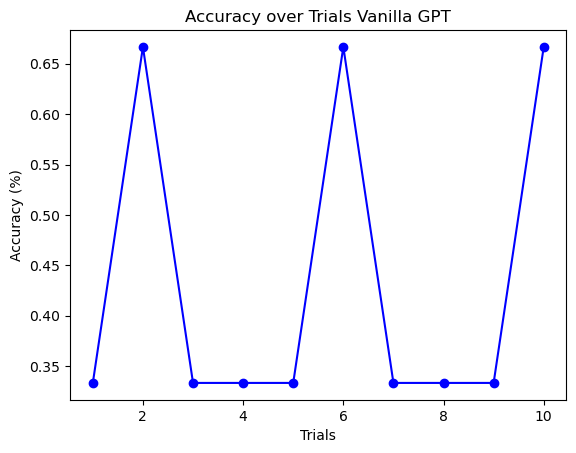

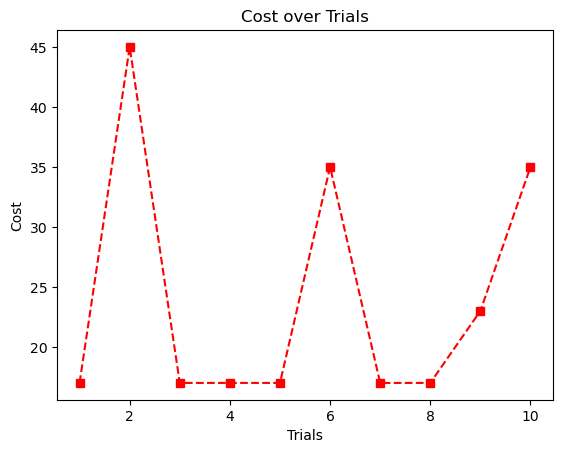

In [1848]:
import numpy as np
import matplotlib.pyplot as plt

prompt, task_list = setup_hard()
print(prompt)

total_accuracy = np.array([])
cost = np.array([])

for i in range(10): 
  setup_hard()
  message = get_GPT_plan(prompt)
  print(f"\n\n message: \n {message}\n\n")
  eval = execute_tasks(message, task_list)
  print(eval[0])
  print(eval[1])
  total_accuracy = np.append(total_accuracy, eval[1])
  cost = np.append(cost, eval[2])

print('Overall accuracy: ', total_accuracy.mean())

# Number of trials (x-axis values)
trials = np.arange(1, len(total_accuracy) + 1)

plt.figure()  # Create a new figure for the first plot
plt.plot(trials, total_accuracy, marker='o', linestyle='-', color='b')
plt.title('Accuracy over Trials Vanilla GPT')
plt.xlabel('Trials')
plt.ylabel('Accuracy (%)')

# Create the second plot for another model (e.g., Model B)
plt.figure()  # Create a new figure for the second plot
plt.plot(trials, cost, marker='s', linestyle='--', color='r')
plt.title('Cost over Trials')
plt.xlabel('Trials')
plt.ylabel('Cost')

# Show both plots
plt.show()



AUTO TRAINING DATA GEN STARTS HERE

In [1849]:
from pprint import pprint
tasks = {
    "go to": {
        "needs": {},  # No specific resource needs  
        "depletes": {},  # No resources are depleted
        "place": {},
        "cost": 5,
    },
    "check": {
        "needs": {},
        "depletes": {},
        "place": {},
        "cost": 3,
    },
    "check inventory": {
        "needs": {},
        "depletes": {}, 
        "place": {},
        "cost": 1,
    }
}

In [1850]:
class Cost(BaseModel):
    cost: int
def set_price(resource):
    message = client.beta.chat.completions.parse(
      model="gpt-4o-2024-08-06",
      messages=[
        {"role": "system", "content": "You are a master task creator for a home environment"},
        {"role": "user", "content": f"""You are tasked with setting the price for {resource}. The price can be between 1 and 20. For context, a toothpase is 5 and soap is 3."""
         }
      ],
      response_format=Cost
    )
    return message.choices[0].message.parsed.cost

set_price("trimmer")

18

In [1851]:
from typing import Dict

class Task(BaseModel):
    task_description: str
    needs: str       # A dictionary of needs, e.g., {"water": 1}
    amount_needs: int
    depletes: str    # A dictionary of depleted resources, e.g., {"water": 1}
    amount_depletes: int
    place: str                  # Location where the task happens, e.g., "kitchen"
    cost: int                   # Associated cost, e.g., 5

class TaskNoNeed(BaseModel):
    task_description: str
    place: str                  # Location where the task happens, e.g., "kitchen"
    cost: int                   # Associated cost, e.g., 5

class Tasks(BaseModel):
    generated_list: list[Task]

task_example = '''"light 2 candles": {
    "needs": {"candle": 2},
    "depletes": {"candle": 0},
    "place": "bedroom",
    "cost": 5
}'''

def task_gen_no_needs(room, tasks_done):
    message = client.beta.chat.completions.parse(
      model="gpt-4o-2024-08-06",
      messages=[
        {"role": "system", "content": "You are a master task creator for a home environment"},
        {"role": "user", "content": f"""You are tasked with creating a task to be done by a butler in a home environment. 
         The task must be something that can be done in a {room}. Give the task descripton in about 3 to 5 words. 
         Lastly, you will assign a cost to the task between 1 and 20. A cost of one might be for dusting the coffee table. 
         A cost of 20 would be for cooking chicken pasta. The format is:{task_example}.""" +
         "Keep resource names in your response singular."+
         "Please avoid creating tasks of this nature since you have already suggested them: " + str(tasks_done)
         }
      ],
      response_format=TaskNoNeed
    )
    return message.choices[0].message.parsed

def task_gen(room, resource_types, min_resources, resource_used):
    message = client.beta.chat.completions.parse(
      model="gpt-4o-2024-08-06",
      messages=[
        {"role": "system", "content": "You are a master task creator for a home environment"},
        {"role": "user", "content": f"""You are tasked with creating a task to be done by a butler in a home environment. 
         The task must be something that can be done in a {room}. Give the task descripton in about 3 to 5 words. You must also decide what resource will be needed. 
         You must decide one resonable resource that the task needs from this list: {resource_types}. 
         You decide how much of a resource will be needed. It must need quantity {min_resources} at the minimum. Be reasonable and use common sense.
         You can choose if the resource will be depleted or not. If you decide to deplete it must be {min_resources}. 
         BEWARE: You do not have to assign anything to be depleted. You can just put nothing in the depletes section and a 0 for amount depleted. 
         Lastly, you will assign a cost to the task between 1 and 20. A cost of one might be for dusting the coffee table. 
         A cost of 20 would be for cooking chicken pasta. The format is:{task_example}.""" + 
         "Please avoid creating a task that uses or in general using these resources: " + str(resource_used) +
         "Keep resource names in your response singular." +
         "Please avoid creating tasks of this nature since you have already suggested them: " + str(tasks.keys()) +
         "Forbidden task names are synomyms of these tasks, like 'Replenish' or 'Purchase' and 'Check'"
        
        }
      ],
      response_format=Task
    )
    return message.choices[0].message.parsed
print(task_gen("kitchen", ["water", "coffee"], 3, "windex"))

windex
task_description='boil water for coffee' needs='water' amount_needs=3 depletes='water' amount_depletes=3 place='kitchen' cost=8


In [1852]:
# Generate Test Data

# push to require:
# trips to the store/buy req = Boolean. This would mean that the sum of resources in rooms and pantry is less than what is needed.

# trips to the pantry/buy refill = N where N < number of rooms involved. A trip to the pantry is needed when the resources in the room are less than what is needed. Namely, number of resources in room are less than
# what the task needs. To achieve complexity N, we initialize the room X with 1 (or more) less than what is needed for the task in room X.

# go to requirements: To force an additional N go to's excluding the ones needed for trips to the store or pantry, add custom tasks in N + 1 different rooms.

# We have sandwiches here: 'go to storage, refill X in X, go to room X' should be triggered in a gold trajectory when a deficit exists.

rooms = ["kitchen", "bedroom", "living room", "garage", "bathroom"]
resource_types = ["toothpaste", "soap", "tomato", "bread", "butter", "milk", "windex", "clorox wipe", "toilet paper", "candle", "apple", "oat"]
def generate_training_data(buy_req=False, trip_req=0, goto_req=0, no_needs = 0, resource_types=resource_types):
    # Update Task List with Refills and buys:
    for resource in resource_types:
        price = set_price(resource)
        tasks["refill " + resource] = { "needs" : {}, "depletes" : {}, "place": "storage", "cost": 5}
        tasks["buy " + resource] = { "needs" : {}, "depletes" : {}, "place": "store", "cost": price}
        
    min_resources = buy_req + trip_req
    min_tasks = goto_req + buy_req + trip_req

    # call gpt and ask for a random task
    # Custom Tasks Generation
    resource_used = []
    gen_tasks = []
    tasks_done = []
    for j in range(no_needs):
        room = rooms[np.random.randint(0, len(rooms))]
        task = task_gen_no_needs(room, tasks_done)
        tasks_done.append(task.task_description.lower())
        tasks[task.task_description.lower()] = { "needs" : {}, "depletes" : {}, "place": room, "cost": task.cost}
        gen_tasks.append(task.task_description.lower())

    for i in range(min_tasks):
        room = rooms[np.random.randint(0, len(rooms))]
        resources = np.random.randint(min_resources+1, min_resources + 3)
        task = task_gen(room, resource_types, resources, resource_used)
        if task.depletes == '':
            task.depletes = task.needs
        tasks[task.task_description.lower()] = { "needs" : {task.needs: task.amount_needs}, "depletes" : {task.depletes: task.amount_depletes}, "place": room, "cost": task.cost}
        resource_used.append(task.needs)
        gen_tasks.append(task.task_description.lower())
    
    return tasks, gen_tasks

tasks, gen_tasks = generate_training_data(buy_req=True, trip_req=2, goto_req=3, no_needs=3)
pprint(tasks, indent=4)

    





[]
['clorox wipe']
['clorox wipe', 'candle']
['clorox wipe', 'candle', 'bread']
['clorox wipe', 'candle', 'bread', 'apple']
['clorox wipe', 'candle', 'bread', 'apple', 'toilet paper']
{   'buy apple': {'cost': 4, 'depletes': {}, 'needs': {}, 'place': 'store'},
    'buy bread': {'cost': 4, 'depletes': {}, 'needs': {}, 'place': 'store'},
    'buy butter': {'cost': 10, 'depletes': {}, 'needs': {}, 'place': 'store'},
    'buy candle': {'cost': 15, 'depletes': {}, 'needs': {}, 'place': 'store'},
    'buy clorox wipe': {   'cost': 6,
                           'depletes': {},
                           'needs': {},
                           'place': 'store'},
    'buy milk': {'cost': 4, 'depletes': {}, 'needs': {}, 'place': 'store'},
    'buy oat': {'cost': 8, 'depletes': {}, 'needs': {}, 'place': 'store'},
    'buy soap': {'cost': 3, 'depletes': {}, 'needs': {}, 'place': 'store'},
    'buy toilet paper': {   'cost': 10,
                            'depletes': {},
                          

In [1853]:
def main_stock_maker(task_list):
    temp_main_stock = {}
    for task in task_list:
        needs_dict = tasks[task]['needs']
        for resource, amount in needs_dict.items():
            temp_main_stock[resource] = temp_main_stock.get(resource, 0) + 0
    return temp_main_stock


In [1854]:

def room_stocks_maker(task_list):
    global room_stocks
    room_stocks.clear()
    resource_set = set()
    temp_room_stocks = {}
    for task in task_list:
        room = tasks[task]['place']
        temp_room_stocks[room] = temp_room_stocks.get(room, {})
        needs_dict = tasks[task]['needs']
        for resource, amount in needs_dict.items():
            temp_room_stocks[room][resource] = temp_room_stocks[room].get(resource, 0) + amount
    temp_room_stocks["store"] = {resource: 0 for resource in resource_set}
    print("I've updated room_stocks", temp_room_stocks)
  
    return temp_room_stocks

        
        

In [1876]:
def setup_game(task_list):
    print("Setting up the game...")
    goto("start")
    room_stocks_filled = room_stocks_maker(task_list)
    main_stock_filled = main_stock_maker(task_list)
    init_main_stock(main_stock_filled)
    init_room_stock(room_stocks_filled)
    prompt = prompt_maker(task_list, CoT=True)
    return prompt, task_list


In [1856]:

prompt, task_list = setup_game(gen_tasks)
new_list = get_GPT_plan(prompt)

Setting up the game...
Moved to start.
Task dict during setup {'go to': {'needs': {}, 'depletes': {}, 'place': {}, 'cost': 5}, 'check': {'needs': {}, 'depletes': {}, 'place': {}, 'cost': 3}, 'check inventory': {'needs': {}, 'depletes': {}, 'place': {}, 'cost': 1}, 'refill toothpaste': {'needs': {}, 'depletes': {}, 'place': 'storage', 'cost': 5}, 'buy toothpaste': {'needs': {}, 'depletes': {}, 'place': 'store', 'cost': 4}, 'refill soap': {'needs': {}, 'depletes': {}, 'place': 'storage', 'cost': 5}, 'buy soap': {'needs': {}, 'depletes': {}, 'place': 'store', 'cost': 3}, 'refill tomato': {'needs': {}, 'depletes': {}, 'place': 'storage', 'cost': 5}, 'buy tomato': {'needs': {}, 'depletes': {}, 'place': 'store', 'cost': 7}, 'refill bread': {'needs': {}, 'depletes': {}, 'place': 'storage', 'cost': 5}, 'buy bread': {'needs': {}, 'depletes': {}, 'place': 'store', 'cost': 4}, 'refill butter': {'needs': {}, 'depletes': {}, 'place': 'storage', 'cost': 5}, 'buy butter': {'needs': {}, 'depletes': {}

Setting up the game...
Already at start.
Task dict during setup {'go to': {'needs': {}, 'depletes': {}, 'place': {}, 'cost': 5}, 'check': {'needs': {}, 'depletes': {}, 'place': {}, 'cost': 3}, 'check inventory': {'needs': {}, 'depletes': {}, 'place': {}, 'cost': 1}, 'refill toothpaste': {'needs': {}, 'depletes': {}, 'place': 'storage', 'cost': 5}, 'buy toothpaste': {'needs': {}, 'depletes': {}, 'place': 'store', 'cost': 4}, 'refill soap': {'needs': {}, 'depletes': {}, 'place': 'storage', 'cost': 5}, 'buy soap': {'needs': {}, 'depletes': {}, 'place': 'store', 'cost': 3}, 'refill tomato': {'needs': {}, 'depletes': {}, 'place': 'storage', 'cost': 5}, 'buy tomato': {'needs': {}, 'depletes': {}, 'place': 'store', 'cost': 7}, 'refill bread': {'needs': {}, 'depletes': {}, 'place': 'storage', 'cost': 5}, 'buy bread': {'needs': {}, 'depletes': {}, 'place': 'store', 'cost': 4}, 'refill butter': {'needs': {}, 'depletes': {}, 'place': 'storage', 'cost': 5}, 'buy butter': {'needs': {}, 'depletes': 

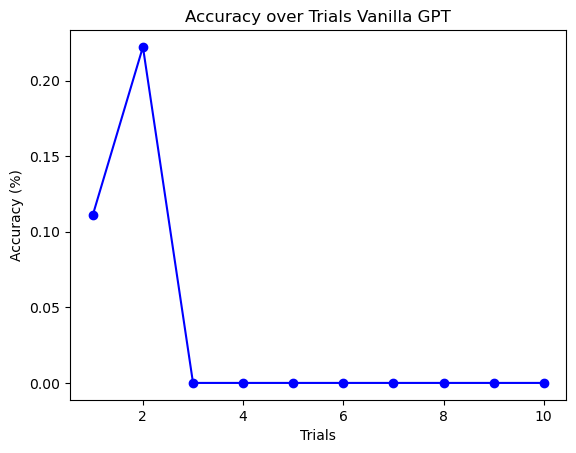

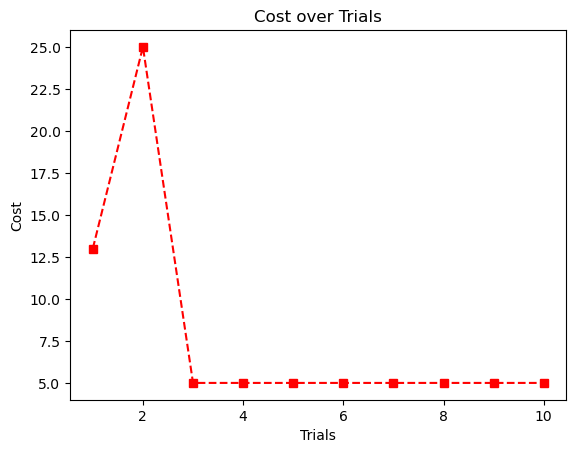

In [1857]:
#execute_tasks(new_list, task_list)
total_accuracy = []
cost = []
for i in range(10): 
  prompt, needed_task_list = setup_game(gen_tasks)
  print("TASKLIST", needed_task_list, prompt)
  candidate_task_list = get_GPT_plan(prompt)
  print(f"\n\n message: \n {candidate_task_list}\n\n")
  eval = execute_tasks(candidate_task_list, needed_task_list)
  print("Outcome: ", eval[0])
  print("Trial accuracy: ", eval[1])
  total_accuracy = np.append(total_accuracy, eval[1])
  cost = np.append(cost, eval[2])

print('Overall accuracy: ', total_accuracy.mean())

# Number of trials (x-axis values)
trials = np.arange(1, len(total_accuracy) + 1)

plt.figure()  # Create a new figure for the first plot
plt.plot(trials, total_accuracy, marker='o', linestyle='-', color='b')
plt.title('Accuracy over Trials Vanilla GPT')
plt.xlabel('Trials')
plt.ylabel('Accuracy (%)')

# Create the second plot for another model (e.g., Model B)
plt.figure()  # Create a new figure for the second plot
plt.plot(trials, cost, marker='s', linestyle='--', color='r')
plt.title('Cost over Trials')
plt.xlabel('Trials')
plt.ylabel('Cost')

# Show both plots
plt.show()

In [1858]:

from collections import defaultdict
def gold_trajectory_generator(needed_task_list):
    setup_game(needed_task_list)
    gold_list = []
    room_to_task = defaultdict(list)
    for task in needed_task_list:
        room_to_task[tasks[task]['place']].append(task)
    for key, value in room_to_task.items():
        gold_list.append("go to " + key)
        for task in value:
            gold_list.append(task)
    return gold_list
print(needed_task_list)            
gold_list = gold_trajectory_generator(gen_tasks)
print(gold_list)

eval = execute_tasks(gold_list, needed_task_list)
print(eval[0])
print(eval[1])

['organize tool bench', 'polish silverware', 'tidy up shelves', 'scrub bathroom surfaces', 'freshen linens and beds', 'prepare cheese sandwiches', 'gather apples', 'dust all surfaces', 'organize spice rack']
Setting up the game...
Moved to start.
Task dict during setup {'go to': {'needs': {}, 'depletes': {}, 'place': {}, 'cost': 5}, 'check': {'needs': {}, 'depletes': {}, 'place': {}, 'cost': 3}, 'check inventory': {'needs': {}, 'depletes': {}, 'place': {}, 'cost': 1}, 'refill toothpaste': {'needs': {}, 'depletes': {}, 'place': 'storage', 'cost': 5}, 'buy toothpaste': {'needs': {}, 'depletes': {}, 'place': 'store', 'cost': 4}, 'refill soap': {'needs': {}, 'depletes': {}, 'place': 'storage', 'cost': 5}, 'buy soap': {'needs': {}, 'depletes': {}, 'place': 'store', 'cost': 3}, 'refill tomato': {'needs': {}, 'depletes': {}, 'place': 'storage', 'cost': 5}, 'buy tomato': {'needs': {}, 'depletes': {}, 'place': 'store', 'cost': 7}, 'refill bread': {'needs': {}, 'depletes': {}, 'place': 'storage'

In [1877]:
import random
export_tasks = {}
# bigger keys are: unique id
# sub keys are: prompt, tasks_dict, needed_tasks, gold_list, gpt_list, gpt_eval, gold_eval

needed_simple_tasks = 10
for i in range(needed_simple_tasks):
    tasks = temp_tasks.copy()
    unique_id = random.randint(10000, 99999)
    export_tasks[unique_id] = {}

    tasks_dict, needed_tasks = generate_training_data(buy_req=True, trip_req=2, goto_req=3, no_needs=3)
    export_tasks[unique_id]["tasks_dict"] = tasks_dict
    export_tasks[unique_id]["needed_tasks"] = needed_tasks
    tasks = tasks_dict.copy()
    gold_list = gold_trajectory_generator(needed_tasks)
    export_tasks[unique_id]["gold_list"] = gold_list

    prompt, task_list = setup_game(needed_tasks)
    export_tasks[unique_id]["prompt"] = prompt

    gpt_list = get_GPT_plan(prompt)
    export_tasks[unique_id]["gpt_list"] = gpt_list

    print("Tasks after generation", tasks)
    print("Room stocks before GPT evaluation: ", room_stocks)
    gpt_eval = execute_tasks(gpt_list, needed_tasks)
    export_tasks[unique_id]["gpt_eval"] = gpt_eval

    print(gpt_eval[0])
    print(gpt_eval[1])

    prompt, task_list = setup_game(needed_tasks)
    print("Room stocks before gold evaluation: ", room_stocks)
    gold_eval = execute_tasks(gold_list, needed_tasks)
    export_tasks[unique_id]["gold_eval"] = gold_eval

    print(gold_eval[0])
    print(gold_eval[1])

pprint(export_tasks, indent=3)




[]
['windex']
['windex', 'clorox wipe']
['windex', 'clorox wipe', 'apple']
['windex', 'clorox wipe', 'apple', 'candle']
['windex', 'clorox wipe', 'apple', 'candle', 'soap']
Setting up the game...
Moved to start.
Task dict during setup {'brush teeth': {'needs': {'toothpaste': 1}, 'depletes': {'toothpaste': 1}, 'place': 'bathroom', 'cost': 15}, 'drink water': {'needs': {'water': 1}, 'depletes': {'water': 1}, 'place': 'kitchen', 'cost': 5}, 'clean dish': {'needs': {'soap': 1}, 'depletes': {'soap': 1}, 'place': 'kitchen', 'cost': 12}, 'make soup': {'needs': {'water': 1, 'tomato': 1}, 'depletes': {'water': 1, 'tomato': 1}, 'place': 'kitchen', 'cost': 12}, 'buy water': {'needs': {}, 'depletes': {}, 'place': 'store', 'cost': 20}, 'buy toothpaste': {'needs': {}, 'depletes': {}, 'place': 'store', 'cost': 4}, 'buy soap': {'needs': {}, 'depletes': {}, 'place': 'store', 'cost': 3}, 'refill toothpaste': {'needs': {}, 'depletes': {}, 'place': 'storage', 'cost': 5}, 'refill soap': {'needs': {}, 'depl

{86481: {'gpt_eval': ('Failure, buying apple failed. Walmart doesnt have enough apple.', 0.6666666666666666, 94), 'gold_eval': ('Success', 1.0, 105)}, 69896: {'gpt_eval': ('FailureMust be at bathroom. You are at bedroom.', 0.2222222222222222, 30), 'gold_eval': ('Success', 1.0, 97)}, 56708: {'gpt_eval': ('FailureMust be at garage. You are at storage.', 0.4444444444444444, 49), 'gold_eval': ('Success', 1.0, 98)}, 35969: {'gpt_eval': ('Success', 1.0, 108), 'gold_eval': ('Success', 1.0, 103)}, 13421: {'gpt_eval': ('FailureMust be at living room. You are at garage.', 0.7777777777777778, 76), 'gold_eval': ('Success', 1.0, 89)}, 86778: {'gpt_eval': ('Failure, buying clorox wipe failed. Walmart doesnt have enough clorox wipe.', 0.0, 5), 'gold_eval': ('Success', 1.0, 103)}, 90556: {'gpt_eval': ('Failure, buying clorox wipe failed. Walmart doesnt have enough clorox wipe.', 0.3333333333333333, 47), 'gold_eval': ('Success', 1.0, 94)}, 69838: {'gpt_eval': ('Failure, refilling soap in bedroom failed

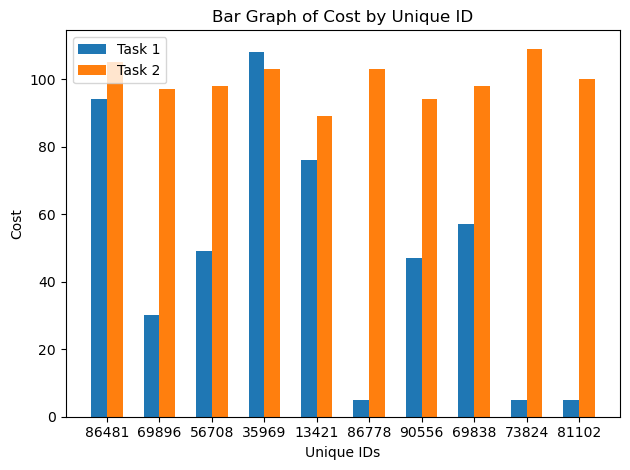

In [1878]:
import matplotlib.pyplot as plt

# Example dictionary
data = {}
for unique_id, subdict in export_tasks.items():
    for key, value in subdict.items():
        if key == "gpt_eval" or key == "gold_eval":
            data[unique_id] = data.get(unique_id, {})
            data[unique_id][key] = data.get(unique_id, {}).get(key, [])
            data[unique_id][key] = value
print(data)

# Prepare the x-axis labels (unique ids) and corresponding bar values
unique_ids = list(data.keys())
tasks = []
third_values = []

for unique_id, subdict in data.items():
    tasks.append(list(subdict.keys()))  # Collect task names for each ID
    third_values.append([value[2] for value in subdict.values()])  # Collect third tuple values

# Number of unique IDs
num_ids = len(unique_ids)

# Positions for bar groups on x-axis
x = np.arange(num_ids)

# Create a bar for each task within a group of unique ids
bar_width = 0.3  # Width of individual bars
fig, ax = plt.subplots()

# Since we have multiple tasks per unique id, loop through the tasks
for i in range(len(tasks[0])):  # Assuming the same number of tasks for each ID
    # Extract the ith task's third value for each unique id
    task_values = [third_values[j][i] for j in range(num_ids)]
    
    # Create a bar for the ith task for each unique id
    ax.bar(x + i * bar_width, task_values, width=bar_width, label=f"Task {i + 1}")

# Customize the plot
ax.set_xlabel("Unique IDs")
ax.set_ylabel("Cost")
ax.set_title("Bar Graph of Cost by Unique ID")
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(unique_ids)  # Set x-axis labels to the unique ids
ax.legend()

# Show plot
plt.tight_layout()
plt.show()


0.38888888888888884
[0.66666667 0.22222222 0.44444444 1.         0.77777778 0.
 0.33333333 0.44444444 0.         0.        ]


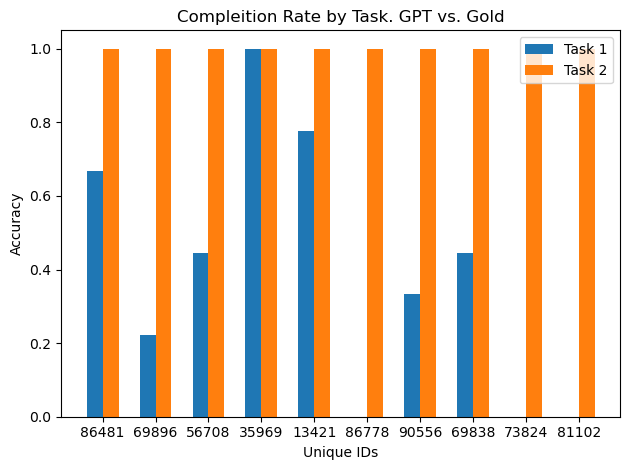

In [1890]:
# Prepare the x-axis labels (unique ids) and corresponding bar values
unique_ids = list(data.keys())
tasks = []
third_values = []

for unique_id, subdict in data.items():
    tasks.append(list(subdict.keys()))  # Collect task names for each ID
    third_values.append([value[1] for value in subdict.values()])  # Collect third tuple values

# Number of unique IDs
num_ids = len(unique_ids)

# Positions for bar groups on x-axis
x = np.arange(num_ids)

# Create a bar for each task within a group of unique ids
bar_width = 0.3  # Width of individual bars
fig, ax = plt.subplots()

# Since we have multiple tasks per unique id, loop through the tasks
for i in range(len(tasks[0])):  # Assuming the same number of tasks for each ID
    # Extract the ith task's third value for each unique id
    task_values = [third_values[j][i] for j in range(num_ids)]
    
    # Create a bar for the ith task for each unique id
    ax.bar(x + i * bar_width, task_values, width=bar_width, label=f"Task {i + 1}")

# Customize the plot
ax.set_xlabel("Unique IDs")
ax.set_ylabel("Accuracy")
ax.set_title("Compleition Rate by Task. GPT vs. Gold")
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(unique_ids)  # Set x-axis labels to the unique ids
ax.legend()

print(np.mean(np.array(third_values)[:,0]))

# Show plot
plt.tight_layout()
plt.show()

In [1897]:
# SayCanPay Impl
# We take the gold trajectory and use discounting factor 0.9
# Each batch is [[needed, history, curr_action, reward], ..., [needed, history, curr_action, reward]]

trajectories = {}

for unique_id, subdict in export_tasks.items():
    for key, value in subdict.items():
        if key == "gold_list":
            trajectories[unique_id] = value

for key, value in trajectories.items():
    trajectory = []
    history = []
    reward = 1
    for action in value:
        trajectory.append([value, history, action, reward])
        history.append(action)
        reward = reward * 0.9
pprint(trajectory)



[]
['go to garage']
['go to garage', 'sort tool shelf']
['go to garage', 'sort tool shelf', 'wash garage floor']
['go to garage', 'sort tool shelf', 'wash garage floor', 'organize paint can']
['go to garage', 'sort tool shelf', 'wash garage floor', 'organize paint can', 'clean car windows']
['go to garage', 'sort tool shelf', 'wash garage floor', 'organize paint can', 'clean car windows', 'organize tool cabinet']
['go to garage', 'sort tool shelf', 'wash garage floor', 'organize paint can', 'clean car windows', 'organize tool cabinet', 'tidy tool area']
['go to garage', 'sort tool shelf', 'wash garage floor', 'organize paint can', 'clean car windows', 'organize tool cabinet', 'tidy tool area', 'go to kitchen']
['go to garage', 'sort tool shelf', 'wash garage floor', 'organize paint can', 'clean car windows', 'organize tool cabinet', 'tidy tool area', 'go to kitchen', 'make apple pie']
['go to garage', 'sort tool shelf', 'wash garage floor', 'organize paint can', 'clean car windows', 'o